Import dependencies and configure settings.

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.api as sm

import hawkes
import markDistributions as md
import scipy.optimize as op

from pylab import rcParams
from __future__ import division

%matplotlib inline
np.set_printoptions(precision=10)

Load data.

In [2]:
dat = 'GOOG_2012-06-21_34200000_57600000_message_10'
temp = ([],[],[],[],[],[])
with open('../../data/'+dat+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temp[0].append(float(row[0]))
        temp[1].append(int(row[1]))
        temp[2].append(int(row[2]))
        temp[3].append(int(row[3]))
        temp[4].append(int(row[4]))
        temp[5].append(int(row[5]))

orders = {'Time':None, 'Type':None, 'Order ID':None,
        'Volume':None, 'Price':None, 'Direction':None}
orders['Time'] = np.asarray(temp[0])
orders['Type'] = np.asarray(temp[1])
orders['Order ID'] = np.asarray(temp[2])
orders['Volume'] = np.asarray(temp[3])
orders['Price'] = np.asarray(temp[4])
orders['Direction'] = np.asarray(temp[5])
del temp

In [3]:
ttemp = len(orders['Type'])
print("{0} order messages total:".format(len(orders['Type'])))
temp = len(orders['Type'][orders['Type']==1])
print("- {0} LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==2])
print("- {0} partial LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==3])
print("- {0} LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} visible LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} hidden LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==7])
print("- {0} trading halts ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

147916 order messages total:
- 71258 LO submissions (48.17%)
- 19 partial LO cancellations (0.01%)
- 64961 LO cancellations (43.92%)
- 7765 visible LO execution (5.25%)
- 3913 hidden LO execution (2.65%)
- 0 trading halts (0.00%)


Extract data into usable form.

In [4]:
LTC_mask = (orders['Type']==1) | (orders['Type']==3) | (orders['Type']==4)
t = orders['Time'][LTC_mask]
x = orders['Volume'][LTC_mask]

j = orders['Type'][LTC_mask]
j[(j==1) & (orders['Direction'][LTC_mask]==-1)] = 0 # limit ask orders
j[(j==1) & (orders['Direction'][LTC_mask]==1)] = 1 # limit bid orders
j[(j==3) & (orders['Direction'][LTC_mask]==-1)] = 2 # limit ask orders cancellation
j[(j==3) & (orders['Direction'][LTC_mask]==1)] = 3 # limit bid orders cancellation
j[(j==4) & (orders['Direction'][LTC_mask]==1)] = 4 # market ask orders
j[(j==4) & (orders['Direction'][LTC_mask]==-1)] = 5 # market bid orders

Initialise a 6-D Hawkes point process and set the parameters.

In [5]:
sparam =[  0.2655821625,   0.2467706365,   0.2488595796,   0.2334196466,   0.0299931322,
   0.0275962919,   0.182111157,    0.0221222508,   0.4824290013,   0.1766814967,
   0.6791265038,   0.3845468916,   0.005365127,    0.1768301375,   0.102805278,
   0.4755566209,   0.3431998706,   0.7105693583,   0.4359995561,   0.1105672259,
   0.1646056628,   0.0026448732,   0.2180595295,   0.4651086535,   0.1036088955,
   0.4019705048,   0.0099944545,   0.185940748,    0.4512819143,   0.2157649044,
   0.0056324858,   0.0057599176,   0.0013837344,   0.0032767781,   0.6608806473,
   0.0037258582,   0.0079340917,   0.0047258357,   0.0059642156,   0.00001,
   0.0094382205,   0.6776540789,  10.,            10.,            10.,            10.,
  10.,            10.,            73.0349372448, 0.,             1.9660371753,
   0.0006869116,   0.8673730157,  25.8972730011,   5.8284634569,   0.0079625467,
   7.1141382424,   0.0245273974,   3.5246200308,   0.0204672999]

In [18]:
d = 6
h = hawkes.Hawkes(d=d)
h.setParam(sparam)
print('Spr(Q)='+str(h.ibParam.getSpectralRadius()))

Spr(Q)=0.848014699666


In [7]:
markDistParam = [[128.56423972,3.275861426],
                [243.9044504278,4.3688862849],
                [97.8188721767,2.4801852406],
                [339.2756753572,5.8696885604],
                [460.4339503846,8.0904052855],
                [1115.865179198,18.8074665174]]
h.setMarkDistParam(markDistParam)

Obtain residual process.

In [8]:
j_, t_, x_, tau, xi = h.Residual(t,j,x)

Q-Q plot:

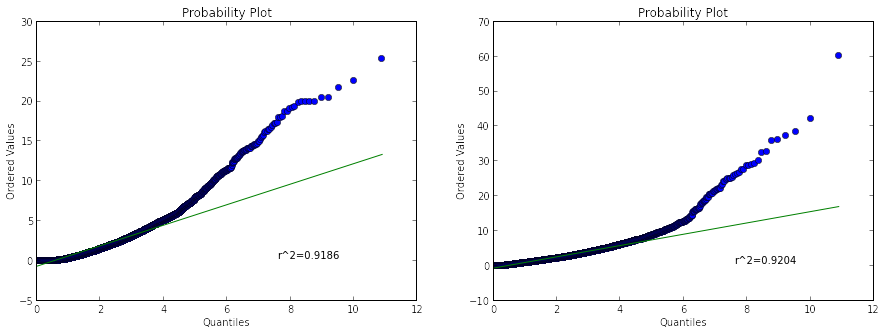

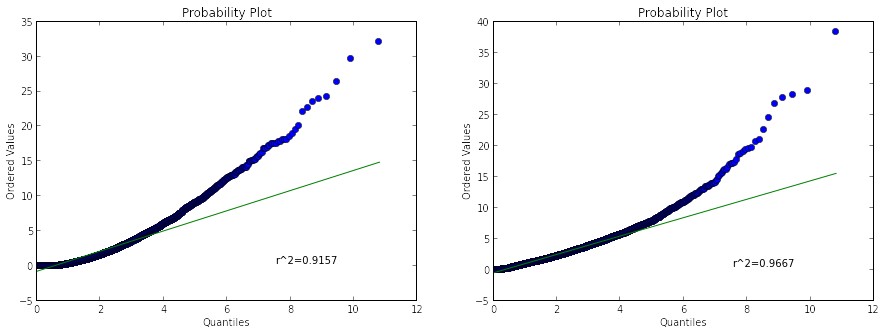

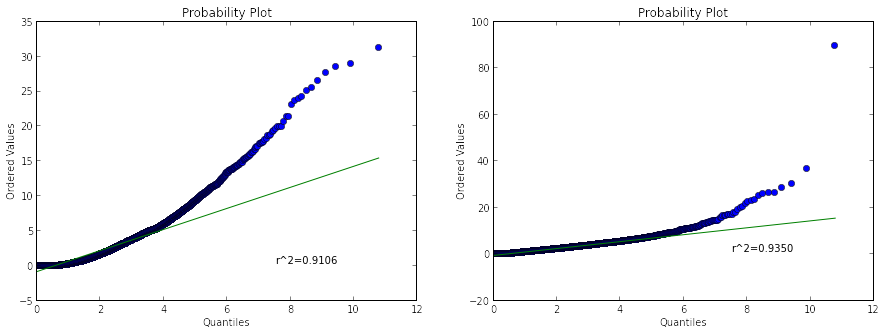

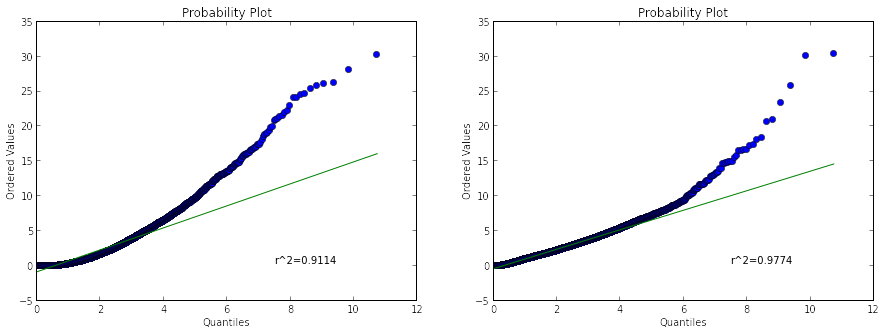

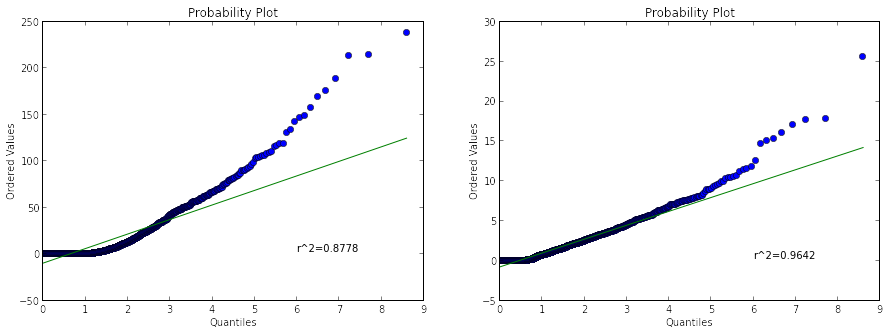

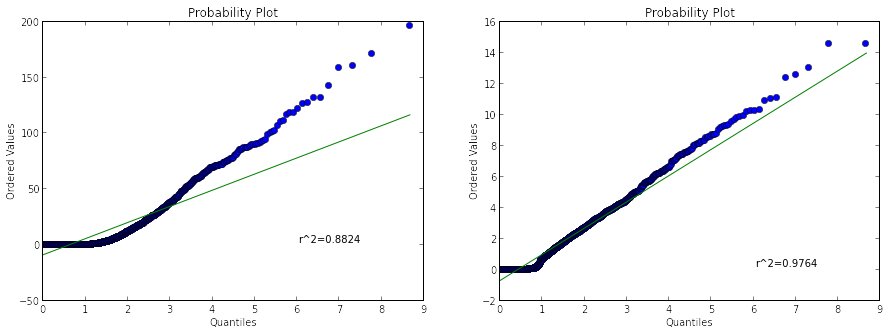

In [16]:
for i in xrange(6):
    s = t_[j_==i]
    intervals = s[1:] - s[:-1]

    r = tau[j_==i]
    intervalr = r[1:] - r[:-1]

    m0 = intervals
    m1 = intervalr

    rcParams['figure.figsize'] = 15, 5
    fig = plt.figure()
    ax1 = plt.subplot(121)
    stats.probplot(m0, dist="expon", plot=plt)
    ax2 = plt.subplot(122)
    stats.probplot(m1, dist="expon", plot=plt)
    plt.show()

Simulation:

In [28]:
numPoints = 150000
simulatedPoints, simulatedIntensities = h.simulate(numPoints)

In [29]:
ttemp = len(simulatedPoints[1])
print("{0} order messages total:".format(ttemp))
temp = len(simulatedPoints[1][simulatedPoints[1]==0])
print("- {0} ask LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(simulatedPoints[1][simulatedPoints[1]==1])
print("- {0} bid LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(simulatedPoints[1][simulatedPoints[1]==2])
print("- {0} ask LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(simulatedPoints[1][simulatedPoints[1]==3])
print("- {0} bid LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} ask MO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} bid MO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

149800 order messages total:
- 41357 ask LO submissions (27.61%)
- 34147 bid LO submissions (22.80%)
- 36255 ask LO cancellations (24.20%)
- 31620 bid LO cancellations (21.11%)
- 7765 ask MO submissions (5.18%)
- 3913 bid MO submissions (2.61%)


Cancellation analysis: